In [19]:
# Load libraries
import pandas as pd
import copy
import numpy as np
import timeit
import matplotlib.pyplot as plt
####
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna, generic_protein
####
from hw4 import neuralnetwork as NN
from hw4 import encoding as EN


## Question 3. Positive and Negative Data.

In [2]:
####read in 
pos = pd.read_csv('rap1-lieb-positives.txt',header=None)[0].tolist()
test = pd.read_csv('rap1-lieb-test.txt',header=None)[0].tolist()
neg = []
#####
f = open('yeast-upstream-1k-negative.fa')
#####
for line in f.readlines():
    if line[0] != '>' :
        neg.append(line.split('\n')[0])
#####


In [10]:
####build training set. 
####Because there are much more positives than negatives, maximize the number of positives in training data
####by also adding reverse complements of positive sequences
pos_total = copy.deepcopy(pos)
for seq in pos:
    my_dna = Seq(seq, generic_dna)
    rc = my_dna.reverse_complement()
    pos_total.append(str(rc))

In [12]:
####check for alignments between pos and negs; throw those out from negs if there are any
max_score = pairwise2.align.localxx(pos[0],pos[0])
max_score = max_score[0][2]
cutoff = 0.9*max_score
####look for alignments between pos and neg
print('before:',len(neg))
i=0
for seq_pos in pos_total:
    for seq_neg in neg:
        if pairwise2.align.localxx(seq_pos,seq_neg)[0][2] > cutoff:
            ###this is if they do have significant overlap
            neg.remove(seq_neg)
print('after',len(neg))


before: 53744
after 603


In [13]:
####save filtered negatives
with open('negs_filtd.txt', 'w') as file:
    for seq in neg:
        file.write(seq)
        file.write('\n')

In [14]:
####save updated positives
with open('pos_filtd.txt', 'w') as file:
    for seq in pos_total:
        file.write(seq)
        file.write('\n')

## Question 2. Encoding and NN architecture.

In [52]:
####read in filtered negatives
with open('negs_filtd.txt', 'r') as file:
    neg = file.read().splitlines()
####read in positives
with open('pos_filtd.txt', 'r') as file:
    pos = file.read().splitlines()

In [53]:
neg_encoded,pos_encoded = EN.encode_pos_neg(neg,pos,17)

In [54]:
neg_encoded[0]

'00010100100001000100100000101000100000011000100010000010100010001000'

## Question 4. K-fold cross validation.

In [40]:
####define parameters
num_parts = 3
#####split up data
neg_chunks,pos_chunks = NN.chunk_kfold(num_parts,neg_encoded,pos_encoded)
#####format training data and get outputs
training_inputs,training_outputs = NN.format_trainingdata(neg_chunks,pos_chunks)

In [ ]:
accuracies = []
step_sizes = [0.1,0.2,0.4,0.8,1.6,3.2]
for step_size in step_sizes:
    tmp_accuracies = []
    for iterations in range(20):
        ######start time
        start = timeit.default_timer()
        #####setup model
        model = NN.NeuralNet(68,8,1,step_size,0.01)
        #####perform k-fold cross validation
        for i in range(len(training_inputs)):
            train_inputs = []
            train_outputs = []
            for j in range(len(training_inputs)):
                if i != j:
                    for item in training_inputs[j]:
                        train_inputs.append(item)
                    for item in training_outputs[j]:
                        train_outputs.append(item)
            #######
            model = NN.train_model(iterations,train_inputs,train_outputs,model)
        ######
        total_inputs = []
        total_outputs = []
        for i in range(len(training_inputs)):
            for j in range(len(training_inputs[i])):
                total_inputs.append(training_inputs[i][j])
                total_outputs.append(training_outputs[i][j])
        pos_predicted,pos_true,neg_predicted,neg_true = NN.call_results(total_inputs,total_outputs,model)
        accuracy = NN.evaluate_accuracy(pos_predicted,pos_true,neg_predicted,neg_true)
        tmp_accuracies.append(accuracy)
        #######stop time
        stop = timeit.default_timer()
        ####print time
        print('Time: ', stop - start)  
    accuracies.append(tmp_accuracies)

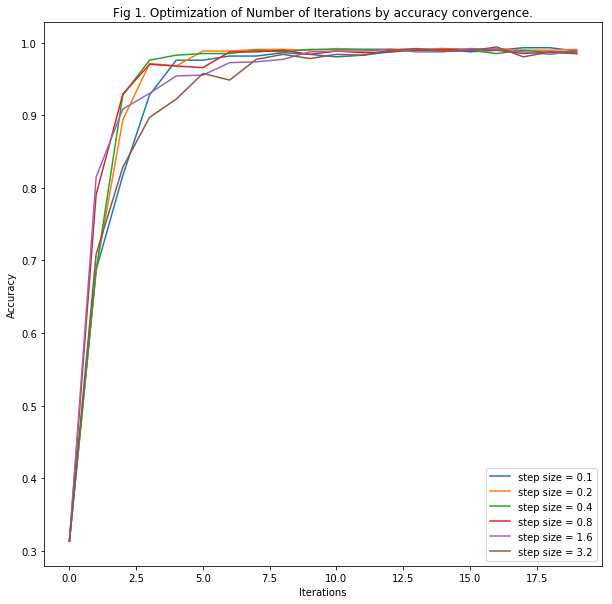

In [42]:
i = 0
plt.figure(figsize=(10,10))
####
for entry in accuracies:
    printme = 'step size = '+str(step_sizes[i])
    #####
    plt.plot(range(20),entry,label=printme)
    ##
    i+=1
####
plt.legend(loc=0)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Fig 1. Optimization of Number of Iterations by accuracy convergence.')
plt.show()
    

In [ ]:
accuracies = []
step_sizes = [0.1,0.2,0.4,0.8,1.6,3.2]
for step_size in step_sizes:
    tmp_accuracies = []
    for num_parts in range(2,20):
        #####split up data
        neg_chunks,pos_chunks = NN.chunk_kfold(num_parts,neg_encoded,pos_encoded)
        #####format training data and get outputs
        training_inputs,training_outputs = NN.format_trainingdata(neg_chunks,pos_chunks)
        ######
        iterations = 5
        ######start time
        start = timeit.default_timer()
        #####setup model
        model = NN.NeuralNet(68,8,1,step_size,0.01)
        #####perform k-fold cross validation
        for i in range(len(training_inputs)):
            train_inputs = []
            train_outputs = []
            for j in range(len(training_inputs)):
                if i != j:
                    for item in training_inputs[j]:
                        train_inputs.append(item)
                    for item in training_outputs[j]:
                        train_outputs.append(item)
            #######
            model = NN.train_model(iterations,train_inputs,train_outputs,model)
        ######
        total_inputs = []
        total_outputs = []
        for i in range(len(training_inputs)):
            for j in range(len(training_inputs[i])):
                total_inputs.append(training_inputs[i][j])
                total_outputs.append(training_outputs[i][j])
        pos_predicted,pos_true,neg_predicted,neg_true = NN.call_results(total_inputs,total_outputs,model)
        accuracy = NN.evaluate_accuracy(pos_predicted,pos_true,neg_predicted,neg_true)
        tmp_accuracies.append(accuracy)
        #######stop time
        stop = timeit.default_timer()
        ####print time
        print('Time: ', stop - start)  
    accuracies.append(tmp_accuracies)

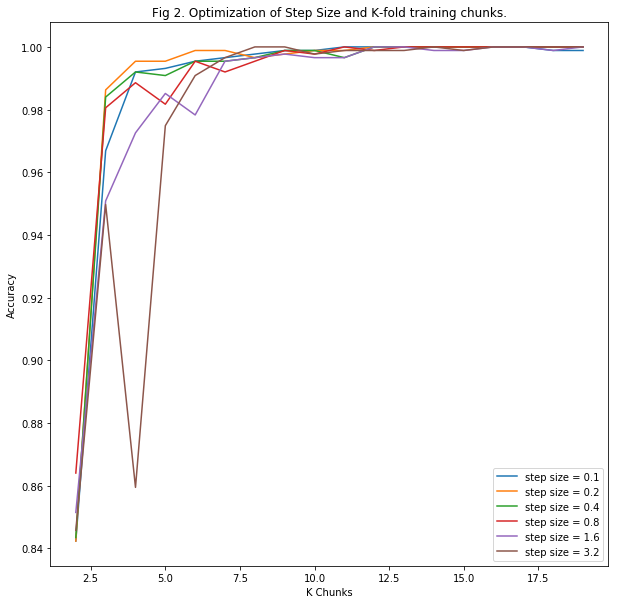

In [37]:
i = 0
plt.figure(figsize=(10,10))
####
for entry in accuracies:
    printme = 'step size = '+str(step_sizes[i])
    #####
    plt.plot(range(2,20),entry,label=printme)
    ##
    i+=1
####
plt.legend(loc=0)
plt.ylabel('Accuracy')
plt.xlabel('K Chunks')
plt.title('Fig 2. Optimization of Step Size and K-fold training chunks.')
plt.show()
    

In [43]:
####define parameters
num_parts = 7
#####split up data
neg_chunks,pos_chunks = NN.chunk_kfold(num_parts,neg_encoded,pos_encoded)
#####format training data and get outputs
training_inputs,training_outputs = NN.format_trainingdata(neg_chunks,pos_chunks)
######define parameters
step_size = 0.2
iterations = 5
######start time
start = timeit.default_timer()
#####setup model
model = NN.NeuralNet(68,8,1,step_size,0.01)
#####perform k-fold cross validation
for i in range(len(training_inputs)):
    train_inputs = []
    train_outputs = []
    for j in range(len(training_inputs)):
        if i != j:
            for item in training_inputs[j]:
                train_inputs.append(item)
            for item in training_outputs[j]:
                train_outputs.append(item)
    #######
    model = NN.train_model(iterations,train_inputs,train_outputs,model)
######
total_inputs = []
total_outputs = []
for i in range(len(training_inputs)):
    for j in range(len(training_inputs[i])):
        total_inputs.append(training_inputs[i][j])
        total_outputs.append(training_outputs[i][j])
pos_predicted,pos_true,neg_predicted,neg_true = NN.call_results(total_inputs,total_outputs,model)
accuracy = NN.evaluate_accuracy(pos_predicted,pos_true,neg_predicted,neg_true)
tmp_accuracies.append(accuracy)
#######stop time
stop = timeit.default_timer()
####print time
print('Time: ', stop - start)  

Time:  1.9254704262129962


In [51]:
print('Printout A. Sample output')
print('This is an output from a positive example:')
model.prop_forward(NN.transform_string(pos_encoded[0]),NN.transform_string('1'))
print(model.layer3_activation)
print('This is an output from a negative example:')
model.prop_forward(NN.transform_string(neg_encoded[0]),NN.transform_string('0'))
print(model.layer3_activation)


Printout A. Sample output
This is an output from a positive example:
[0.93518982]
This is an output from a negative example:
[3.10463163e-09]
